In [1]:
# Import required modules.
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [168]:
# Read the data into ds.
ds = pd.read_csv('../data/MIT-BIH_Arrhythmia_Database.csv')

In [169]:
# Show the head of ds.
ds.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [170]:
# Show the shape of ds.
ds.shape

(100689, 34)

In [171]:
# Check for duplicates in ds.
ds[ds.duplicated()].sum()

record              0
type                0
0_pre-RR            0
0_post-RR         0.0
0_pPeak           0.0
0_tPeak           0.0
0_rPeak           0.0
0_sPeak           0.0
0_qPeak           0.0
0_qrs_interval      0
0_pq_interval       0
0_qt_interval       0
0_st_interval       0
0_qrs_morph0      0.0
0_qrs_morph1      0.0
0_qrs_morph2      0.0
0_qrs_morph3      0.0
0_qrs_morph4      0.0
1_pre-RR            0
1_post-RR         0.0
1_pPeak           0.0
1_tPeak           0.0
1_rPeak           0.0
1_sPeak           0.0
1_qPeak           0.0
1_qrs_interval      0
1_pq_interval       0
1_qt_interval       0
1_st_interval       0
1_qrs_morph0      0.0
1_qrs_morph1      0.0
1_qrs_morph2      0.0
1_qrs_morph3      0.0
1_qrs_morph4      0.0
dtype: object

 - No duplicates found

In [172]:
# Check for missing values in ds.
ds.isnull().sum()

record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

 - No missing values shown

In [173]:
# Get the statistics of ds.
dt = ds.describe().round()

In [174]:
# Show statistics of the first 16 columns.
dt.iloc[:, :16]

,record,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,174.0,279.0,279.0,0.0,0.0,1.0,-0.0,-0.0,28.0,11.0,60.0,20.0,-0.0,0.0,0.0,1.0
std,52.0,82.0,81.0,0.0,1.0,1.0,1.0,0.0,15.0,9.0,40.0,30.0,0.0,0.0,1.0,1.0
min,100.0,11.0,6.0,-3.0,-2.0,-2.0,-4.0,-4.0,0.0,1.0,5.0,1.0,-4.0,-3.0,-3.0,-3.0
25%,115.0,230.0,230.0,-0.0,-0.0,1.0,-1.0,-0.0,18.0,5.0,33.0,1.0,-0.0,-0.0,-0.0,0.0
50%,203.0,267.0,266.0,0.0,0.0,1.0,-1.0,-0.0,27.0,7.0,46.0,8.0,-0.0,-0.0,0.0,0.0
75%,219.0,324.0,322.0,0.0,1.0,1.0,1.0,-0.0,38.0,16.0,75.0,23.0,-0.0,0.0,1.0,1.0
max,234.0,2114.0,2114.0,4.0,4.0,4.0,4.0,3.0,170.0,150.0,334.0,141.0,3.0,3.0,3.0,3.0


In [175]:
# Show statistics of the last 17 columns.
dt.iloc[:, 17:]

,1_pre-RR,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,279.0,279.0,0.0,0.0,-0.0,-0.0,-0.0,11.0,10.0,36.0,14.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,82.0,81.0,0.0,0.0,1.0,1.0,0.0,12.0,9.0,17.0,9.0,0.0,0.0,1.0,1.0,1.0
min,11.0,6.0,-2.0,-2.0,-4.0,-6.0,-5.0,0.0,1.0,5.0,1.0,-5.0,-4.0,-4.0,-4.0,-5.0
25%,230.0,230.0,-0.0,0.0,-0.0,-1.0,-1.0,3.0,5.0,25.0,10.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,267.0,266.0,0.0,0.0,-0.0,-0.0,-0.0,7.0,8.0,33.0,12.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,324.0,322.0,0.0,1.0,0.0,-0.0,-0.0,18.0,13.0,45.0,17.0,-0.0,-0.0,0.0,0.0,-0.0
max,2114.0,2114.0,5.0,7.0,4.0,3.0,4.0,260.0,185.0,412.0,215.0,4.0,4.0,3.0,4.0,3.0


In [176]:
# Check the value counts of the target column.
ds.type.value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

- N represents normal while VEB, SVEB, F, and Q represents arrhythmia

In [177]:
# Transform multi-class labels into binary-class (1 and 0).
ds['type'] = ds.type.map({'N': 0, 'VEB': 1, 'SVEB': 1, 'F': 1, 'Q': 1})

In [178]:
# Check the value counts of the target column.
ds.type.value_counts()

type
0    90083
1    10606
Name: count, dtype: int64

In [179]:
#  Create a function to split the data.
def split_data(df):
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_full_train = df_full_train['type'].values
    y_test = df_test.type.values
    y_train = df_train.type.values
    y_val = df_val.type.values

    del df_full_train['type']
    del df_test['type']
    del df_train['type']
    del df_val['type']

    sm = SMOTE(random_state=22)
    df_full_train_sm, y_full_train_sm = sm.fit_resample(df_full_train, y_full_train)
    df_train_sm, y_train_sm = sm.fit_resample(df_train, y_train)
    
    dv = DictVectorizer(sparse=False)

    full_train_dicts = df_full_train_sm.to_dict(orient='records')
    test_dicts = df_test.to_dict(orient='records')
    train_dicts = df_train_sm.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_full_train = dv.fit_transform(full_train_dicts)
    X_test = dv.transform(test_dicts)    
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return  X_full_train, X_test, X_train, X_val, y_full_train_sm, y_test, y_train_sm, y_val, dv

In [180]:
# Create function to get the score.
def get_score(alg):
    _, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)
    model = alg.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = round(roc_auc_score(y_val, y_pred), 4)

    return score, y_val, y_pred

## First Training

### Logistic Regression Algorithm

In [181]:
# Calculate the probability ROC AUC score.
df = ds.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9567


### Random Forest Classifier

In [182]:
# Calculate the probability ROC AUC score.
df = ds.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9989


### Gradient Boosting Classifier

In [183]:
# Calculate the probability ROC AUC score.
df = ds.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9934


### XGB Classifier

In [184]:
# Define a function to create dtrain and dval.
def get_dicts(df):
    _, _, X_train, X_val, _, _, y_train, y_val, dv = split_data(df)

    features = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

    return dtrain, dval, y_val

In [185]:
# Create function to get xgb score.
def xgb_score(xgb_params):
    dtrain, dval, y_val = get_dicts(df)
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    score = roc_auc_score(y_val, y_pred)

    return score, y_val, y_pred

In [186]:
# Calculate the ROC AUC score.
df = ds.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_xgb = 0.9955


In [187]:
# Define numerical columns and split into two sets.
col_num = ds.drop(columns="type").columns.to_list()
set_one = col_num[:16]
set_two = col_num[17:]

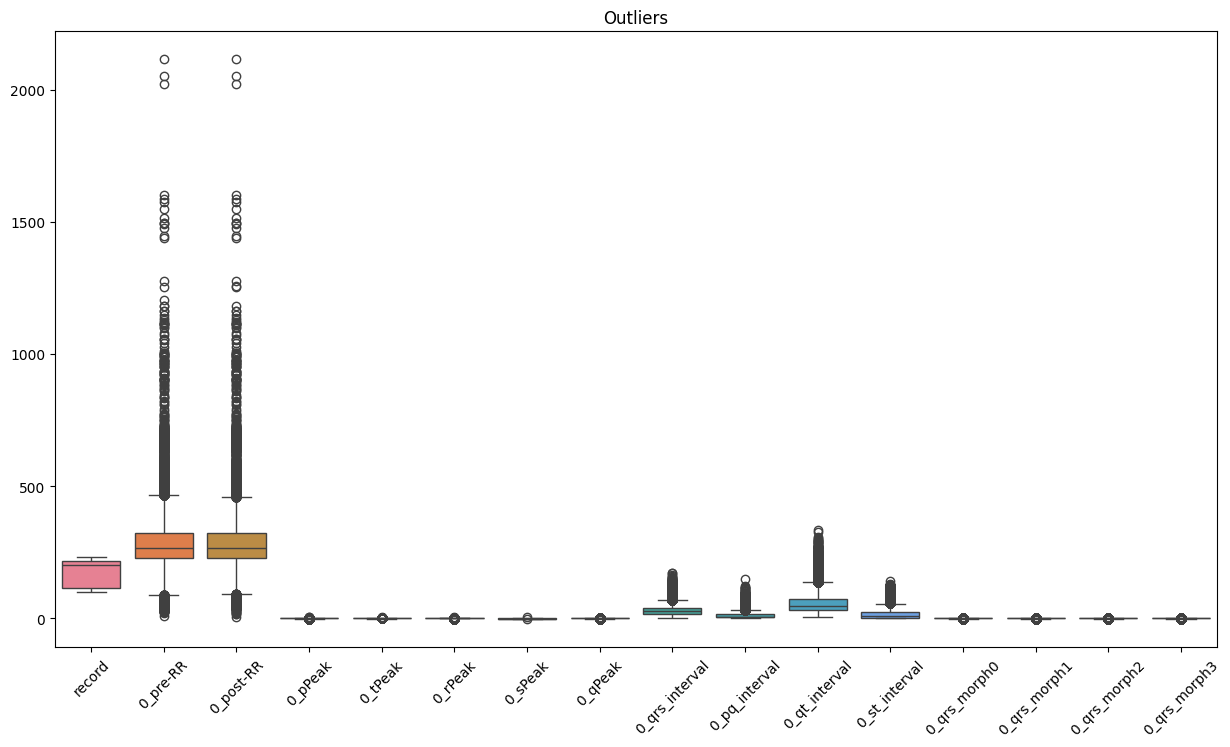

In [188]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=ds[set_one])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

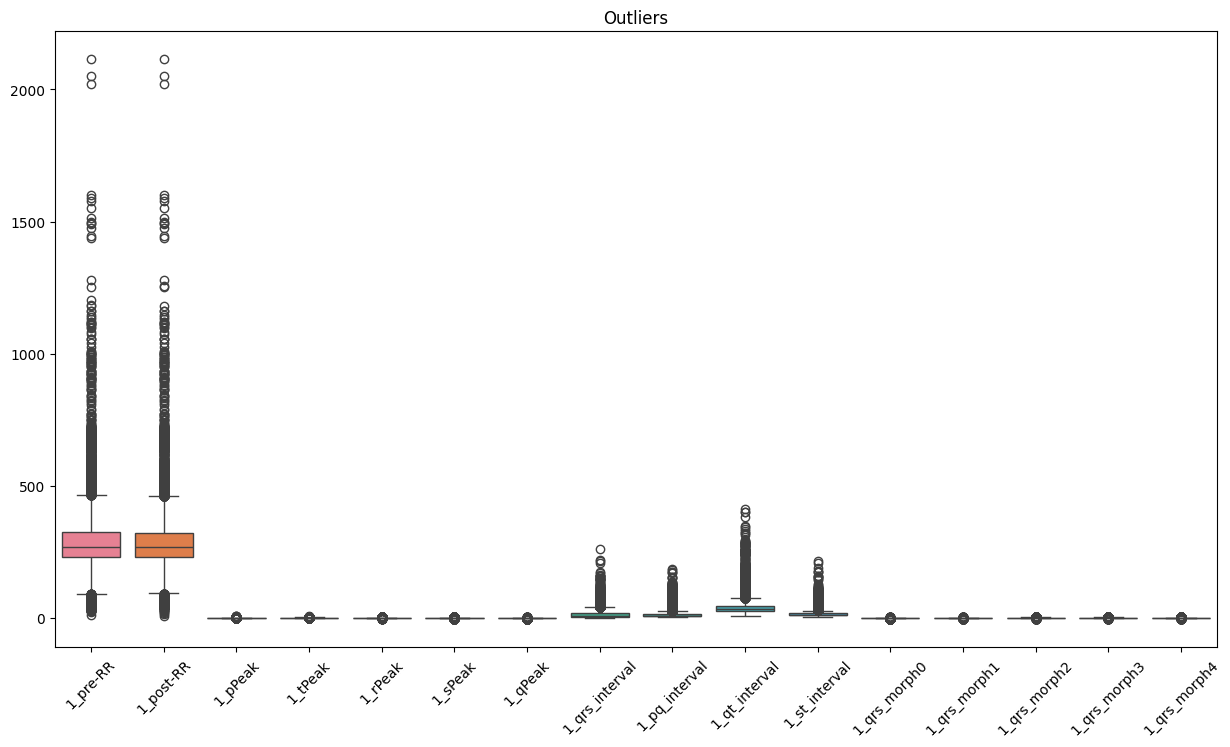

In [189]:
# Draw boxplot of the second set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=ds[set_two])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

In [198]:
# Function to remove_outlier
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    lower  = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    df_remove = df_in[~((df_in[col_name] < lower) | (df_in[col_name] > upper))]
    return df_remove

In [ ]:
# Define columns with outliers.
out_col = []

In [194]:
# Remove outliers.
for col in ds.columns.to_list():
    de = remove_outlier(ds, col)

In [195]:
# Show the shape of new dataframe.
de.shape

(93702, 34)

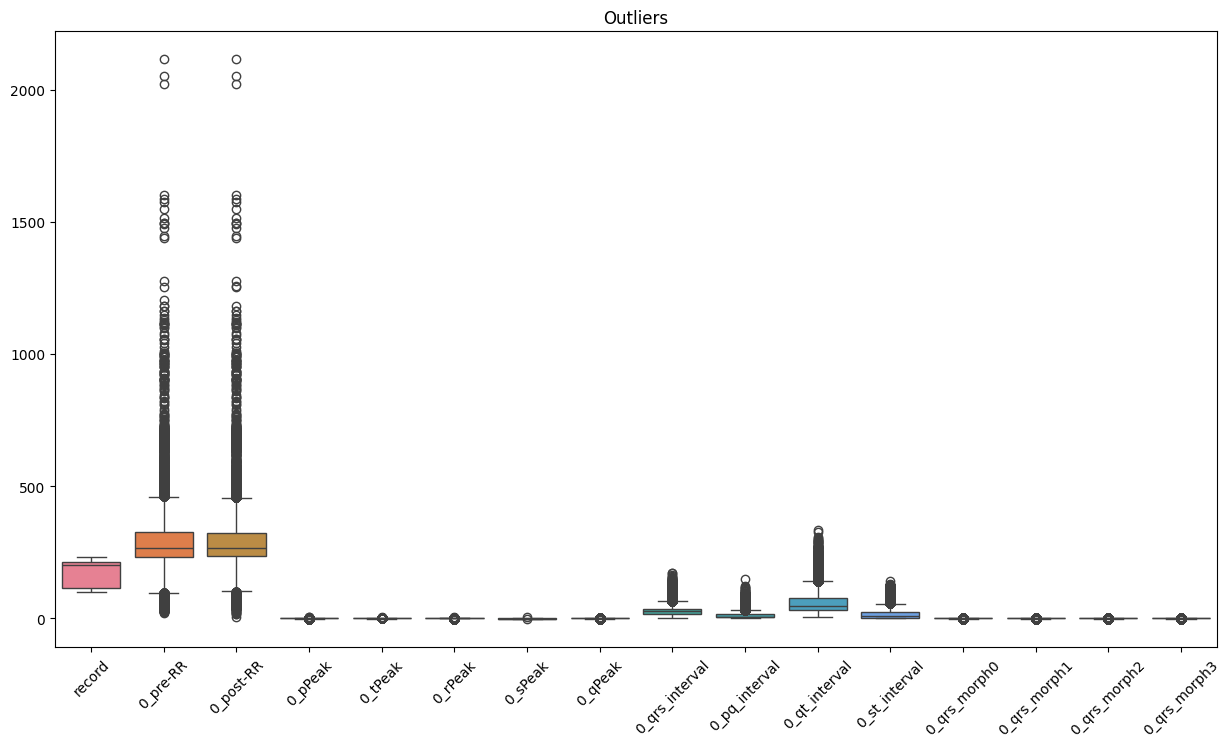

In [196]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_one])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

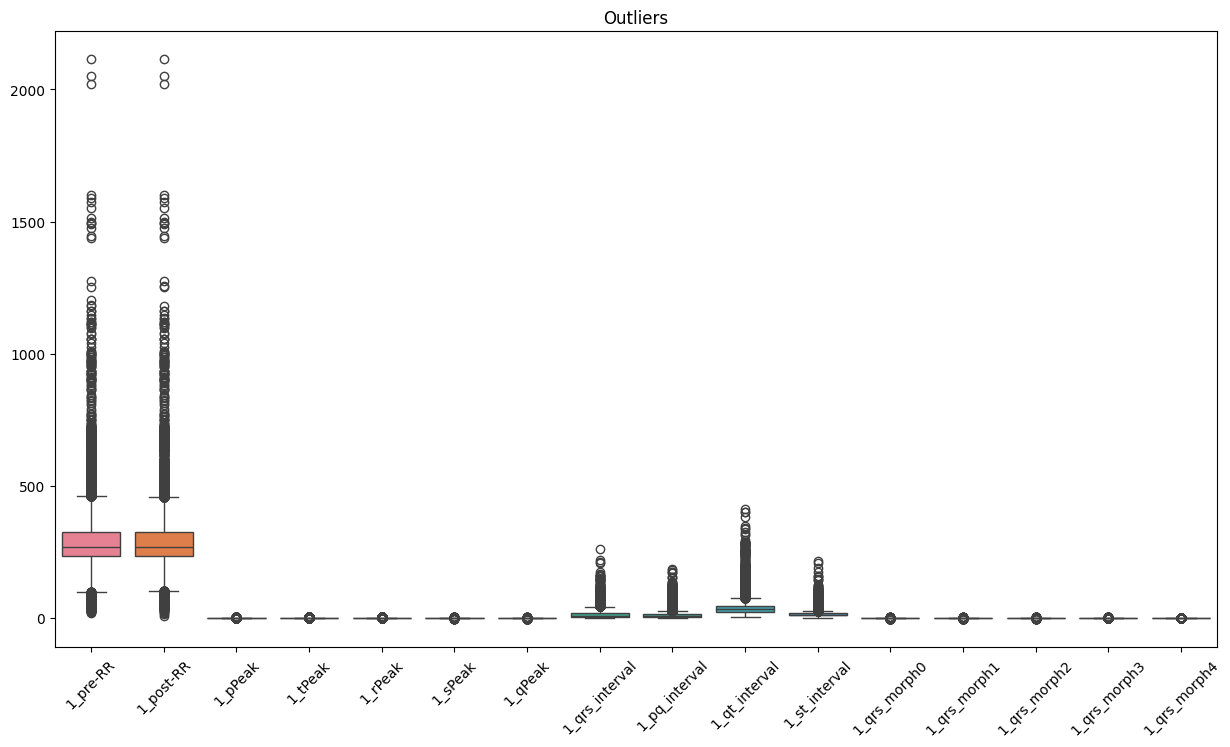

In [197]:
# Draw boxplot of the second set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_two])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

## Second Training

### Logistic Regression Algorithm

In [29]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9627


### Random Forest Classifier

In [30]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9988


### Gradient Boosting Classifier

In [31]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9945


### XGB Classifier

In [32]:
# Calculate the ROC AUC score.
df = dr.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_gbc, y_val, y_pred = xgb_score(xgb_params)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9954


In [33]:
# Check for correletion.
corr = de[col_num].corr().round(2)

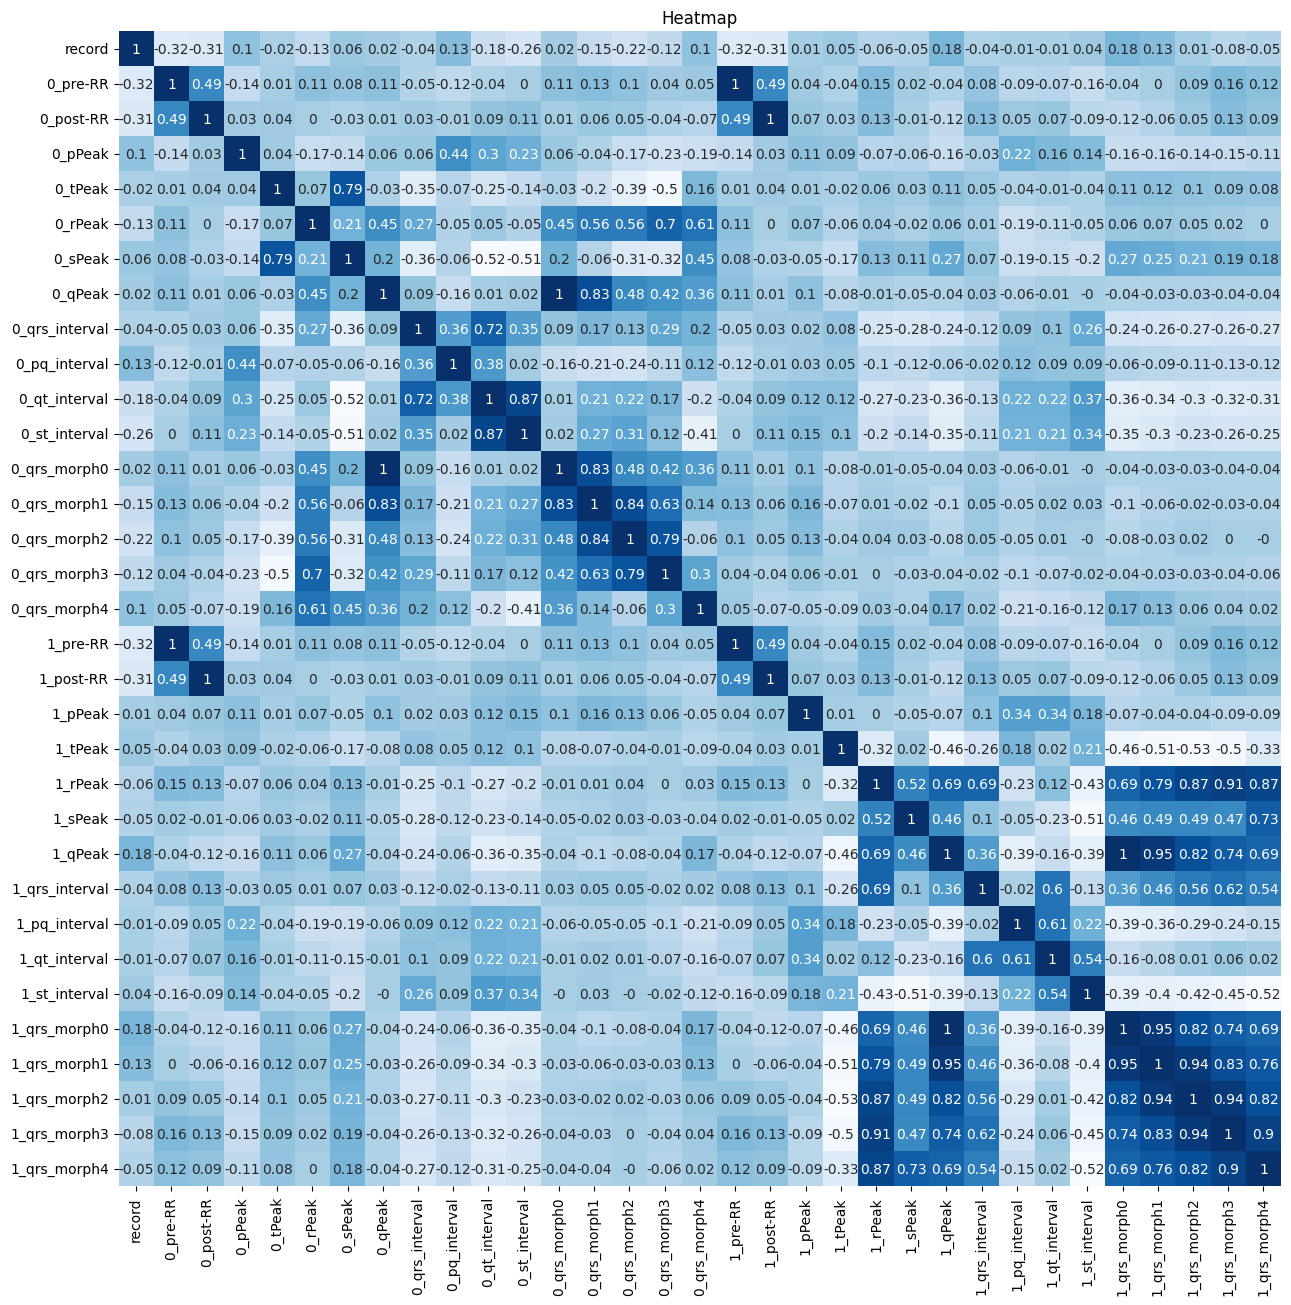

In [34]:
# Draw the correlation heatmap.
plt.figure(figsize=(15, 15))
plt.title('Heatmap')
sns.heatmap(corr, cmap='Blues', annot=True, cbar=False);

In [35]:
# Unstack the correlation values.
du = corr.unstack().sort_values(ascending=False)

In [36]:
# Check the length of df_unstack.
len(du)

1089

In [37]:
# Show the first 40 records of df_unstack.
du[:40]

1_qrs_morph4    1_qrs_morph4      1.0
1_qrs_morph3    1_qrs_morph3      1.0
1_qrs_morph2    1_qrs_morph2      1.0
1_qrs_morph1    1_qrs_morph1      1.0
1_qrs_morph0    1_qrs_morph0      1.0
                1_qPeak           1.0
1_st_interval   1_st_interval     1.0
1_qt_interval   1_qt_interval     1.0
1_pq_interval   1_pq_interval     1.0
1_qrs_interval  1_qrs_interval    1.0
1_qPeak         1_qrs_morph0      1.0
                1_qPeak           1.0
1_sPeak         1_sPeak           1.0
1_rPeak         1_rPeak           1.0
1_tPeak         1_tPeak           1.0
1_pPeak         1_pPeak           1.0
1_post-RR       1_post-RR         1.0
                0_post-RR         1.0
0_pre-RR        0_pre-RR          1.0
1_pre-RR        1_pre-RR          1.0
                0_pre-RR          1.0
0_qrs_morph4    0_qrs_morph4      1.0
0_qrs_morph3    0_qrs_morph3      1.0
0_qrs_morph2    0_qrs_morph2      1.0
0_qrs_morph1    0_qrs_morph1      1.0
0_qrs_morph0    0_qrs_morph0      1.0
            

In [38]:
# Show the next 40 records of df_unstack.
du[41:80]

1_qPeak        1_qrs_morph1     0.95
1_qrs_morph1   1_qrs_morph0     0.95
               1_qPeak          0.95
1_qrs_morph0   1_qrs_morph1     0.95
1_qrs_morph1   1_qrs_morph2     0.94
1_qrs_morph2   1_qrs_morph3     0.94
1_qrs_morph3   1_qrs_morph2     0.94
1_qrs_morph2   1_qrs_morph1     0.94
1_qrs_morph3   1_rPeak          0.91
1_rPeak        1_qrs_morph3     0.91
1_qrs_morph3   1_qrs_morph4     0.90
1_qrs_morph4   1_qrs_morph3     0.90
0_st_interval  0_qt_interval    0.87
1_rPeak        1_qrs_morph4     0.87
               1_qrs_morph2     0.87
1_qrs_morph4   1_rPeak          0.87
1_qrs_morph2   1_rPeak          0.87
0_qt_interval  0_st_interval    0.87
0_qrs_morph1   0_qrs_morph2     0.84
0_qrs_morph2   0_qrs_morph1     0.84
0_qrs_morph0   0_qrs_morph1     0.83
0_qPeak        0_qrs_morph1     0.83
1_qrs_morph1   1_qrs_morph3     0.83
1_qrs_morph3   1_qrs_morph1     0.83
0_qrs_morph1   0_qrs_morph0     0.83
               0_qPeak          0.83
1_qrs_morph0   1_qrs_morph2     0.82
1

In [39]:
# List the highly correlated columns.
remove_corr = ['1_pre-RR', '1_post-RR', '0_qrs_morph0', '1_qrs_morph0', 
               '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4']

In [40]:
# Remove the highly correlated columns.
de = de.drop(columns=remove_corr)

 - This is the final data

In [41]:
# Show the shape of de.
de.shape

(93702, 26)

## Logistic Regression

### Train Model

In [42]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9573


In [43]:
# Define ROC curve plot function.
def roc_curve_draw(y_val, y_pred):
    plt.figure(figsize=(5, 5))
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, label='probability')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

    plt.title('ROC Curve')
    plt.legend()
    
    return plt.show()

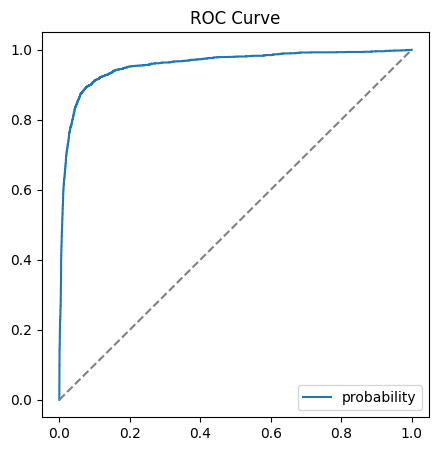

In [44]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [45]:
# Define the confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [46]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1831,3361,92,13457
20,0.2,1752,1671,171,15147
30,0.3,1649,912,274,15906
40,0.4,1509,573,414,16245
50,0.5,1395,394,528,16424
60,0.6,1279,290,644,16528
70,0.7,1189,214,734,16604
80,0.8,1047,158,876,16660
90,0.9,847,106,1076,16712


### Precision and Recall

In [47]:
# Define the precision-recall plot function.
def pre_rec_plot(df_scores):
    # Calculate the precision and recall.
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)  
    
    # Plot the curves.
    plt.plot(df_scores.threshold, df_scores.p, label='precision')
    plt.plot(df_scores.threshold, df_scores.r, label='recall')

    plt.title('Precision-Recall Curves')
    plt.legend()
    
    return plt.show()

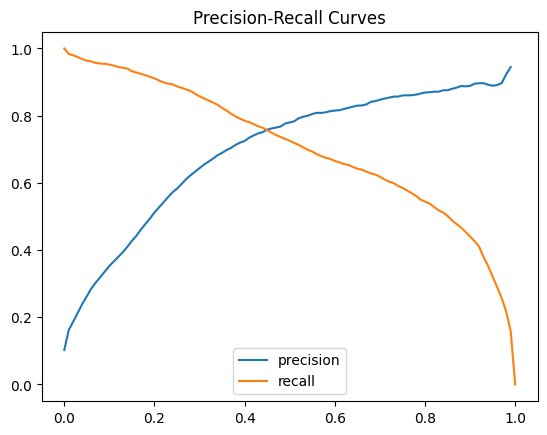

In [48]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [49]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [50]:
# Get the maximum f1-score.
f1_max_lr = df_scores['f1'].max()
print(f'f1_max_lr = {round(f1_max_lr, 4)}')

f1_max_lr = 0.7578


In [51]:
# Define the f1 plot function.
def f1_plot(df_scores):
    plt.plot(df_scores.threshold, df_scores.f1)
    plt.xticks(np.linspace(0, 1, 11))
    plt.title('F1 Curve')
    
    return plt.show()

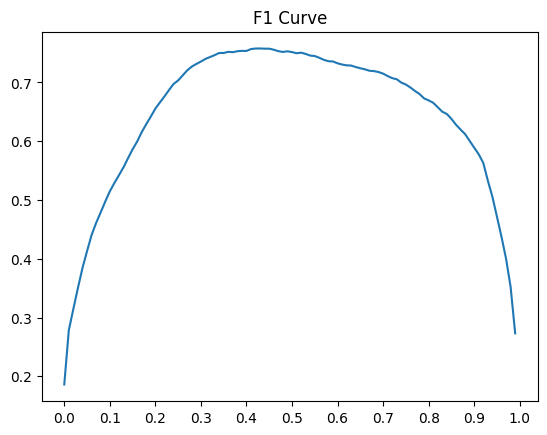

In [52]:
# Plot the F1 scores.
f1_plot(df_scores)

## Random Forest Classifier

### Train Model

In [53]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.999


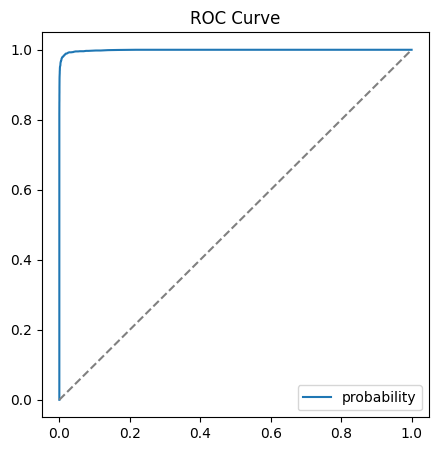

In [54]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [55]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1915,1160,8,15658
20,0.2,1909,569,14,16249
30,0.3,1902,336,21,16482
40,0.4,1890,204,33,16614
50,0.5,1874,109,49,16709
60,0.6,1842,51,81,16767
70,0.7,1791,18,132,16800
80,0.8,1715,6,208,16812
90,0.9,1569,0,354,16818


### Precision and Recall

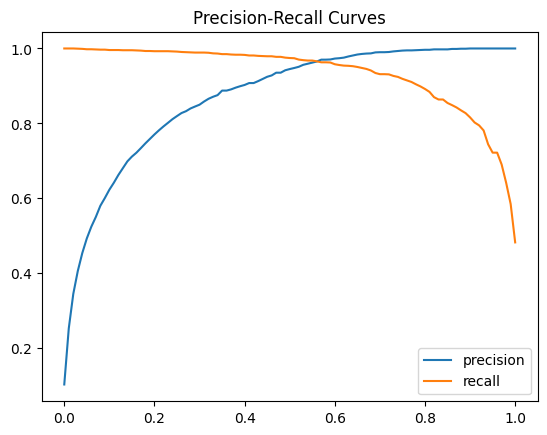

In [56]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [57]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [58]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9669


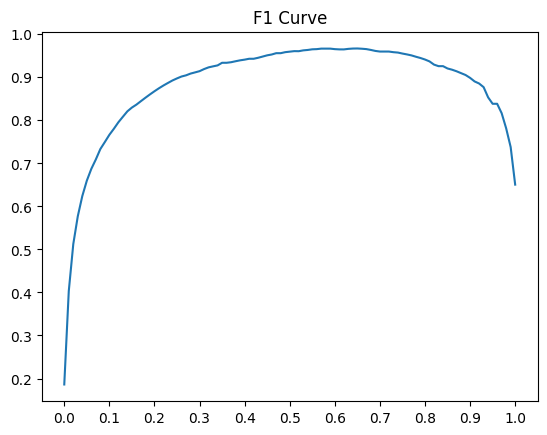

In [59]:
# Plot the F1 scores.
f1_plot(df_scores)

## Gradient Boosting Classifier

In [60]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9945


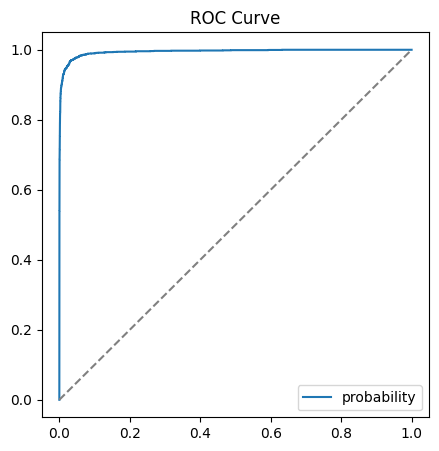

In [61]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [62]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1909,2204,14,14614
20,0.2,1897,1255,26,15563
30,0.3,1882,868,41,15950
40,0.4,1866,607,57,16211
50,0.5,1839,437,84,16381
60,0.6,1816,276,107,16542
70,0.7,1779,171,144,16647
80,0.8,1714,89,209,16729
90,0.9,1591,42,332,16776


### Precision and Recall

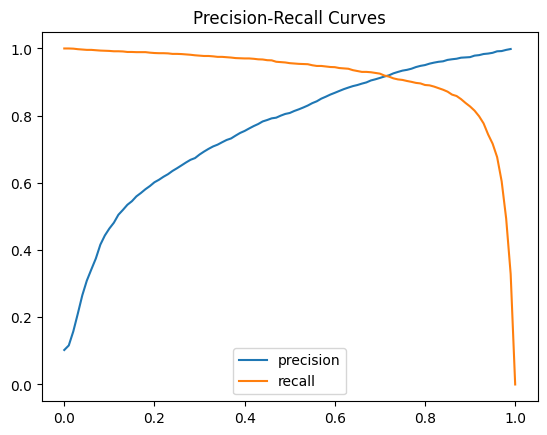

In [63]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [64]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [65]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9214


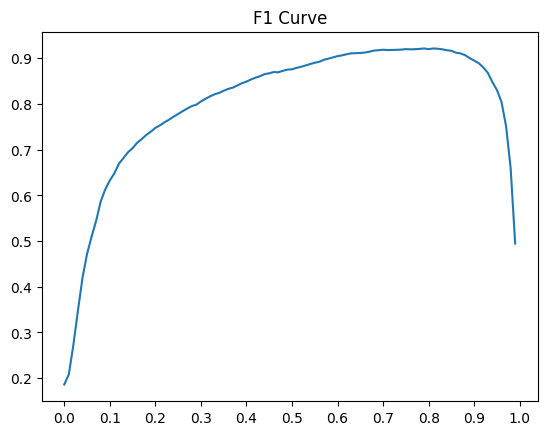

In [66]:
# Plot the F1 scores.
f1_plot(df_scores)

### XGB Classifier

In [67]:
# Calculate the ROC AUC score.
df = dr.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_xgb = 0.9954


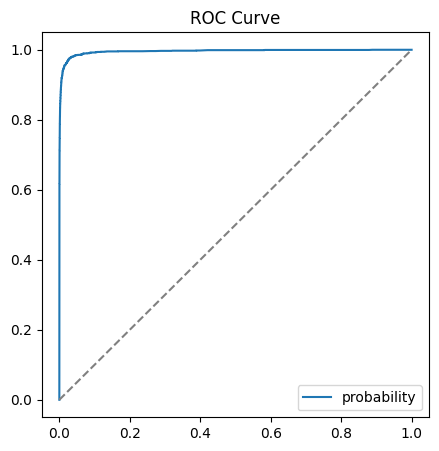

In [68]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [69]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1911,1806,12,15012
20,0.2,1895,958,28,15860
30,0.3,1886,687,37,16131
40,0.4,1873,463,50,16355
50,0.5,1850,341,73,16477
60,0.6,1830,236,93,16582
70,0.7,1804,157,119,16661
80,0.8,1752,102,171,16716
90,0.9,1620,37,303,16781


### Precision and Recall

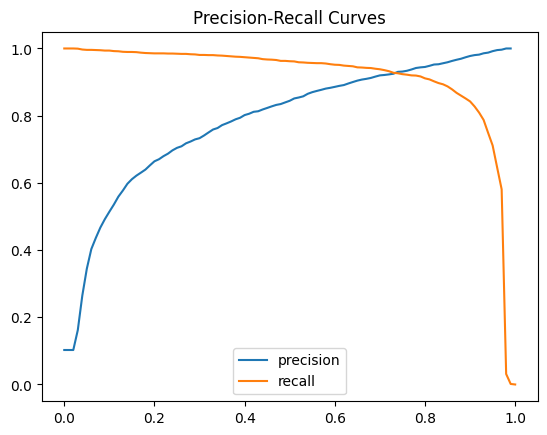

In [70]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [71]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [72]:
# Get the maximum f1-score.
f1_max_xgb = df_scores['f1'].max()
print(f'f1_max_xgb = {round(f1_max_xgb, 4)}')

f1_max_xgb = 0.9305


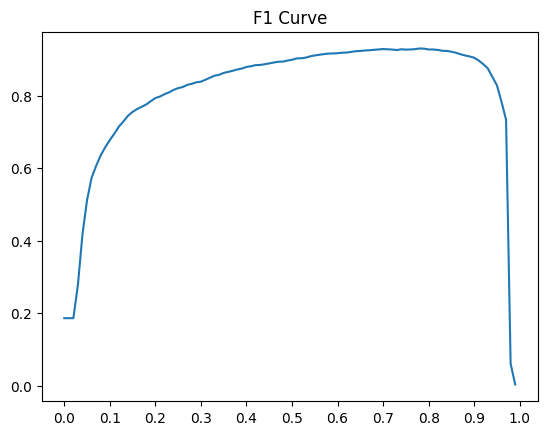

In [73]:
# Plot the F1 scores.
f1_plot(df_scores)

## Feature Importances

### Logistic Regression

In [74]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [75]:
# Apply the feature elimination technique.
original_score = score_lra
scores = pd.DataFrame(columns=['eliminated_feature', 'score_lr', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values
    
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [76]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_lr,difference
1,0_pre-RR,0.910614,0.046686
2,0_post-RR,0.945590,0.011710
0,record,0.946017,0.011283
5,0_rPeak,0.947863,0.009437
4,0_tPeak,0.952005,0.005295
17,1_tPeak,0.953745,0.003555
3,0_pPeak,0.954230,0.003070
18,1_rPeak,0.955565,0.001735
15,0_qrs_morph4,0.955749,0.001551
13,0_qrs_morph2,0.955918,0.001382


### Random Forest Classifier

In [77]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [78]:
# Apply the feature elimination technique.
original_score = score_rfc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_rf', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [79]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_rf,difference
1,0_pre-RR,0.996902,0.002098
2,0_post-RR,0.997319,0.001681
22,1_pq_interval,0.997650,0.001350
7,0_qPeak,0.997828,0.001172
19,1_sPeak,0.997930,0.001070
4,0_tPeak,0.998019,0.000981
0,record,0.998031,0.000969
13,0_qrs_morph2,0.998034,0.000966
8,0_qrs_interval,0.998085,0.000915
16,1_pPeak,0.998088,0.000912


### Gradient Boosting Classifier

In [80]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [81]:
# Apply the feature elimination technique.
original_score = score_gbc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_gb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = GradientBoostingClassifier(n_estimators=100, random_state=22)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [82]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_gb,difference
1,0_pre-RR,0.983044,0.011456
0,record,0.988044,0.006456
5,0_rPeak,0.989823,0.004677
2,0_post-RR,0.989909,0.004591
20,1_qPeak,0.991003,0.003497
17,1_tPeak,0.991256,0.003244
9,0_pq_interval,0.991592,0.002908
11,0_st_interval,0.991609,0.002891
12,0_qrs_morph1,0.991633,0.002867
6,0_sPeak,0.991637,0.002863


### XGB Classifier

In [83]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [84]:
# Apply the feature elimination technique.
original_score = score_xgb
scores = pd.DataFrame(columns=['eliminated_feature', 'score_xgb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)
    
    features_x = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features_x = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features_x]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_x)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_x)
    
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'binary:logistic',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    mod_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

    y_pred = mod_xgb.predict(dval)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [85]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_xgb,difference
1,0_pre-RR,0.988395,0.007029
0,record,0.993332,0.002092
5,0_rPeak,0.993352,0.002072
24,1_st_interval,0.993388,0.002036
16,1_pPeak,0.993500,0.001924
14,0_qrs_morph3,0.993566,0.001858
13,0_qrs_morph2,0.993584,0.001840
22,1_pq_interval,0.993901,0.001523
3,0_pPeak,0.994012,0.001412
20,1_qPeak,0.994101,0.001323


## Model Tuning

### Logistic Regression

In [86]:
# Create function to train the kfold.
def train_kfold(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [87]:
# Create function to predict the kfold.
def predict_kfold(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [88]:
# Copy the data to be used.
df = de.copy()

In [89]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [90]:
# Define the columns.
columns = df.drop(columns='type').columns.to_list()

In [91]:
# Initiate the kfold.
kfold = KFold(n_splits=5, shuffle=True, random_state=22)

the_scores = []

for C in tqdm([x / 40.0 for x in range(16, 33, 1)]):

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['type'].values
        y_val = df_val['type'].values

        dv, model = train_kfold(df_train, y_train, C=C)
        y_pred = predict_kfold(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    the_scores.append((C, np.mean(scores)))

df_scores = pd.DataFrame(the_scores, columns=['C', 'score'])

  0%|          | 0/17 [00:00<?, ?it/s]

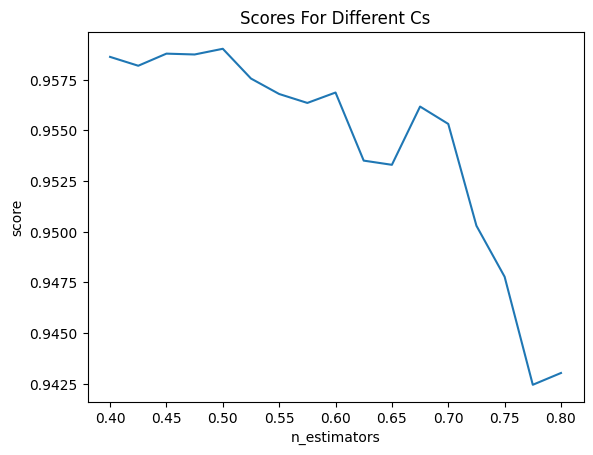

In [92]:
# Plot the scores.
plt.plot(df_scores.C, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different Cs')
plt.show()

In [93]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.959


In [94]:
# Get the index of the maximum score .
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 4


In [95]:
# Find the C at the index.
max_C = df_scores.C[index]
print(f'max_C = {max_C}')

max_C = 0.5


### Random Forest Classifier

#### For n_estimators

In [96]:
# Copy the data to be used.
df = de.copy()

In [97]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [98]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 20)):
    rfc = RandomForestClassifier(n_estimators=n, random_state=22, n_jobs=-1)
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

  0%|          | 0/6 [00:00<?, ?it/s]

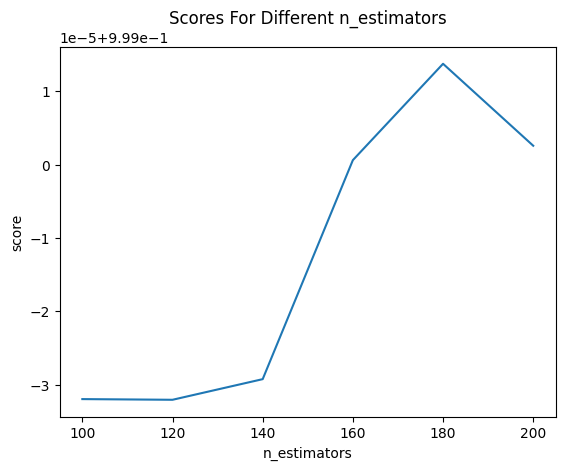

In [99]:
# Plot the scores.
plt.plot(df_scores.n_estimators, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different n_estimators')
plt.show()

In [100]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.999


In [101]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 4


In [102]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 180


#### For max_depth

In [103]:
# Copy the data to be used.
df = de.copy()

In [104]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [105]:
# Find the best maximum depth.
scores = []

for d in tqdm([2, 4, 6, 8]):
    rfc = RandomForestClassifier(n_estimators=0,
                               max_depth=d,
                               random_state=22, 
                               n_jobs=-1)

    for n in tqdm(range(100, 201, 25)):
        rfc.n_estimators = n
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

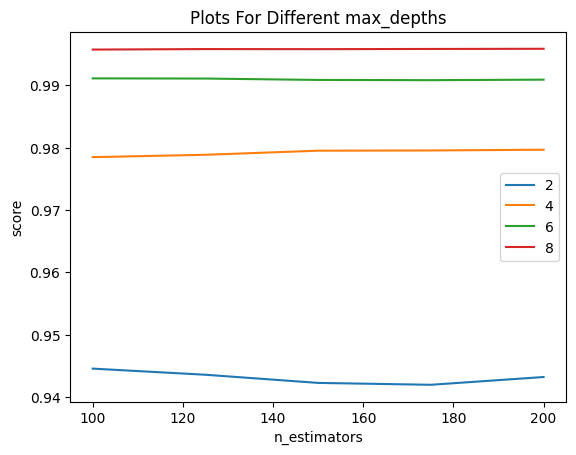

In [106]:
# Plot the scores.
for d in [2, 4, 6, 8]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.score, label=d)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Plots For Different max_depths')
plt.legend()
plt.show()

In [107]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9959


In [108]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 19


In [109]:
# Find the d at the index.
max_d = df_scores.max_depth[index]
print(f'max_d = {max_d}')

max_d = 8


In [110]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


### Gradient Boosting Classifier

#### For n_estimators

In [111]:
# Copy the data to be used.
df = de.copy()

In [112]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [113]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 20)):
    gbc = GradientBoostingClassifier(n_estimators=n, random_state=22)
    gbc.fit(X_train, y_train)
    
    y_pred = gbc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

  0%|          | 0/6 [00:00<?, ?it/s]

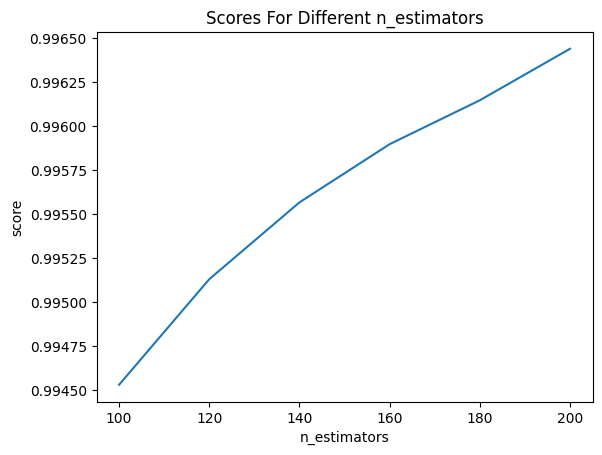

In [116]:
# Plot the scores.
plt.plot(df_scores.n_estimators, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different n_estimators')
plt.show()

In [117]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9964


In [118]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 5


In [119]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


#### For learning_rate

In [120]:
# Copy the data to be used.
df = de.copy()

In [121]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [122]:
# Find the best learning rate.
scores = []

for l in tqdm([0.1, 0.2, 0.3]):
    gbc = GradientBoostingClassifier(n_estimators=0, learning_rate=l, random_state=22)

    for n in tqdm(range(100, 201, 20)):
        gbc.n_estimators = n
        gbc.fit(X_train, y_train)

        y_pred = gbc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((l, n, score))

columns = ['learning_rate', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

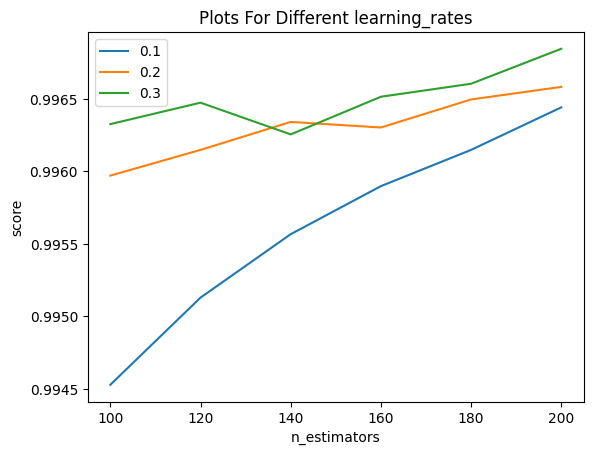

In [123]:
# Plot the scores.
for l in [0.1, 0.2, 0.3]:
    df_subset = df_scores[df_scores.learning_rate == l]
    plt.plot(df_subset.n_estimators, df_subset.score, label=l)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Plots For Different learning_rates')
plt.legend()
plt.show()

In [124]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9968


In [125]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 17


In [126]:
# Find the l at the index.
max_l = df_scores.learning_rate[index]
print(f'max_l = {max_l}')

max_l = 0.3


In [127]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


### XGB Classifier

In [128]:
# Copy the data to be used.
df = de.copy()

In [129]:
# Define a function to parse the output.
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [130]:
# Get dtrain and dval.
dtrain, dval, _ = get_dicts(df)

In [131]:
# Initialize the process.
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [132]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [133]:
# Store values for 'eta=0.3'.
scores['eta=0.1'] = parse_xgb_output(output)

In [134]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [135]:
# Store values for 'eta=0.3'.
scores['eta=0.3'] = parse_xgb_output(output)

In [136]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [137]:
# Store values for 'eta=0.5'.
scores['eta=0.5'] = parse_xgb_output(output)

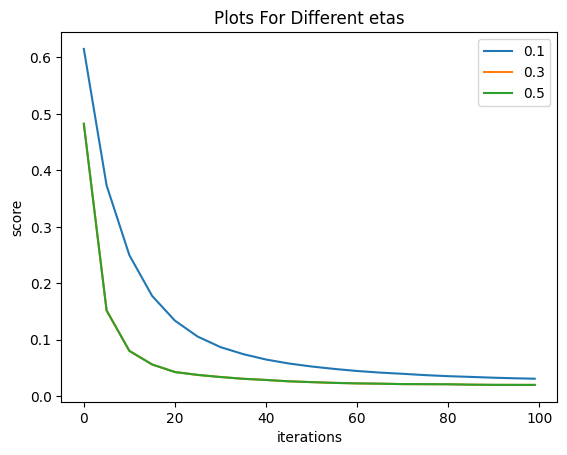

In [138]:
# Inspect the results.
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.plot(scores['eta=0.5'].num_iter, scores['eta=0.3'].val_auc, label='0.5')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Plots For Different etas')
plt.legend()
plt.show()

In [139]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [140]:
# Store values for 'max_depth=4'.
scores['max_depth=4'] = parse_xgb_output(output)

In [141]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 8,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [142]:
# Store values for 'max_depth=8'.
scores['max_depth=8'] = parse_xgb_output(output)

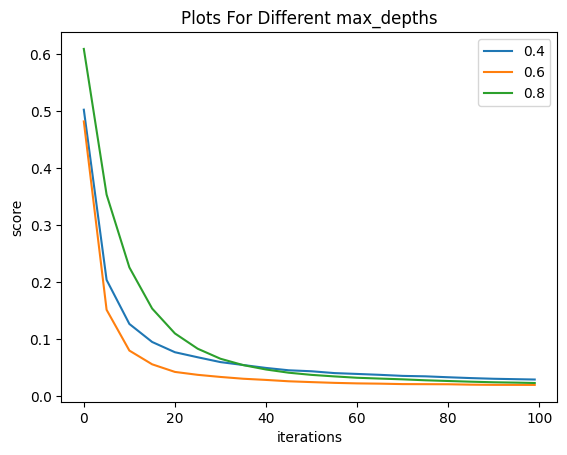

In [143]:
# Inspect the results.
plt.plot(scores['max_depth=4'].num_iter, scores['max_depth=4'].val_auc, label='0.4')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.6')
plt.plot(scores['max_depth=8'].num_iter, scores['max_depth=8'].val_auc, label='0.8')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Plots For Different max_depths')
plt.legend()
plt.show()

## Running Time

### Logistic Regression Algorithm

In [144]:
# Time the final model.
start_1 = time.time()

df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=0.5, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

end_1 = time.time()
print(f'time_lra = {round(end_1 - start_1, 2)}')

score_lra = 0.9575
time_lra = 15.15


### Random Forest Classifier

In [145]:
# Time the final model.
start_2 = time.time()

df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

end_2 = time.time()
print(f'time_rfc = {round(end_2 - start_2, 2)}')

score_rfc = 0.9959
time_rfc = 44.8


### Gradient Boosting Classifier

In [146]:
# Time the final model.
start_3 = time.time()

df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

end_3 = time.time()
print(f'time_gbc = {round(end_3 - start_3, 2)}')

score_gbc = 0.9945
time_gbc = 126.62


### XGB Classifier

In [148]:
# Time the final model.
start_4 = time.time()

df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 8,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

end_4 = time.time()
print(f'time_xgb = {round(end_4 - start_4, 2)}')

score_xgb = 0.9965
time_xgb = 10.43
